In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
path = r'S:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

train_dataset_path_I = os.path.abspath(os.path.join(path, 'train_dataset_method_I_balanced'))
GUT_test_path_I = os.path.join(path, 'GUT_test_method_I_balanced').replace("\\", "/")
ITU_YU_test_path_I = os.path.join(path, 'ITU_YU_test_method_I_balanced').replace("\\", "/")
MAAP_test_path_I = os.path.join(path, 'MAAP_test_method_I_balanced').replace("\\", "/")

train_dataset_path_II = os.path.abspath(os.path.join(path, 'train_dataset_method_II_balanced'))
GUT_test_path_II = os.path.join(path, 'GUT_test_method_II_balanced').replace("\\", "/")
ITU_YU_test_path_II = os.path.join(path, 'ITU_YU_test_method_II_balanced').replace("\\", "/")
MAAP_test_path_II = os.path.join(path, 'MAAP_test_method_II_balanced').replace("\\", "/")

# Load datasets
train_I = tf.data.Dataset.load(train_dataset_path_I)
GUT_test_I = tf.data.Dataset.load(GUT_test_path_I)
ITU_YU_test_I = tf.data.Dataset.load(ITU_YU_test_path_I)
MAAP_test_I = tf.data.Dataset.load(MAAP_test_path_I)

train_II = tf.data.Dataset.load(train_dataset_path_II)
GUT_test_II = tf.data.Dataset.load(GUT_test_path_II)
ITU_YU_test_II = tf.data.Dataset.load(ITU_YU_test_path_II)
MAAP_test_II = tf.data.Dataset.load(MAAP_test_path_II)

full_test_I = GUT_test_I.concatenate(ITU_YU_test_I).concatenate(MAAP_test_I)
full_test_II = GUT_test_II.concatenate(ITU_YU_test_II).concatenate(MAAP_test_II)

In [3]:
emotions = ["Happy", "Sad", "Angry", "Fear", "Disgusted", "Surprised"]

## MODEL I

In [28]:
def masked_categorical_crossentropy(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [29]:
model_method_I = tf.keras.models.load_model('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Models/model_method_I/model.keras', custom_objects={ 'masked_categorical_crossentropy': masked_categorical_crossentropy})

In [26]:
 from keras.utils.visualize_util import plot  
 plot(model_method_I, to_file='model.png')  

ModuleNotFoundError: No module named 'keras.utils.visualize_util'

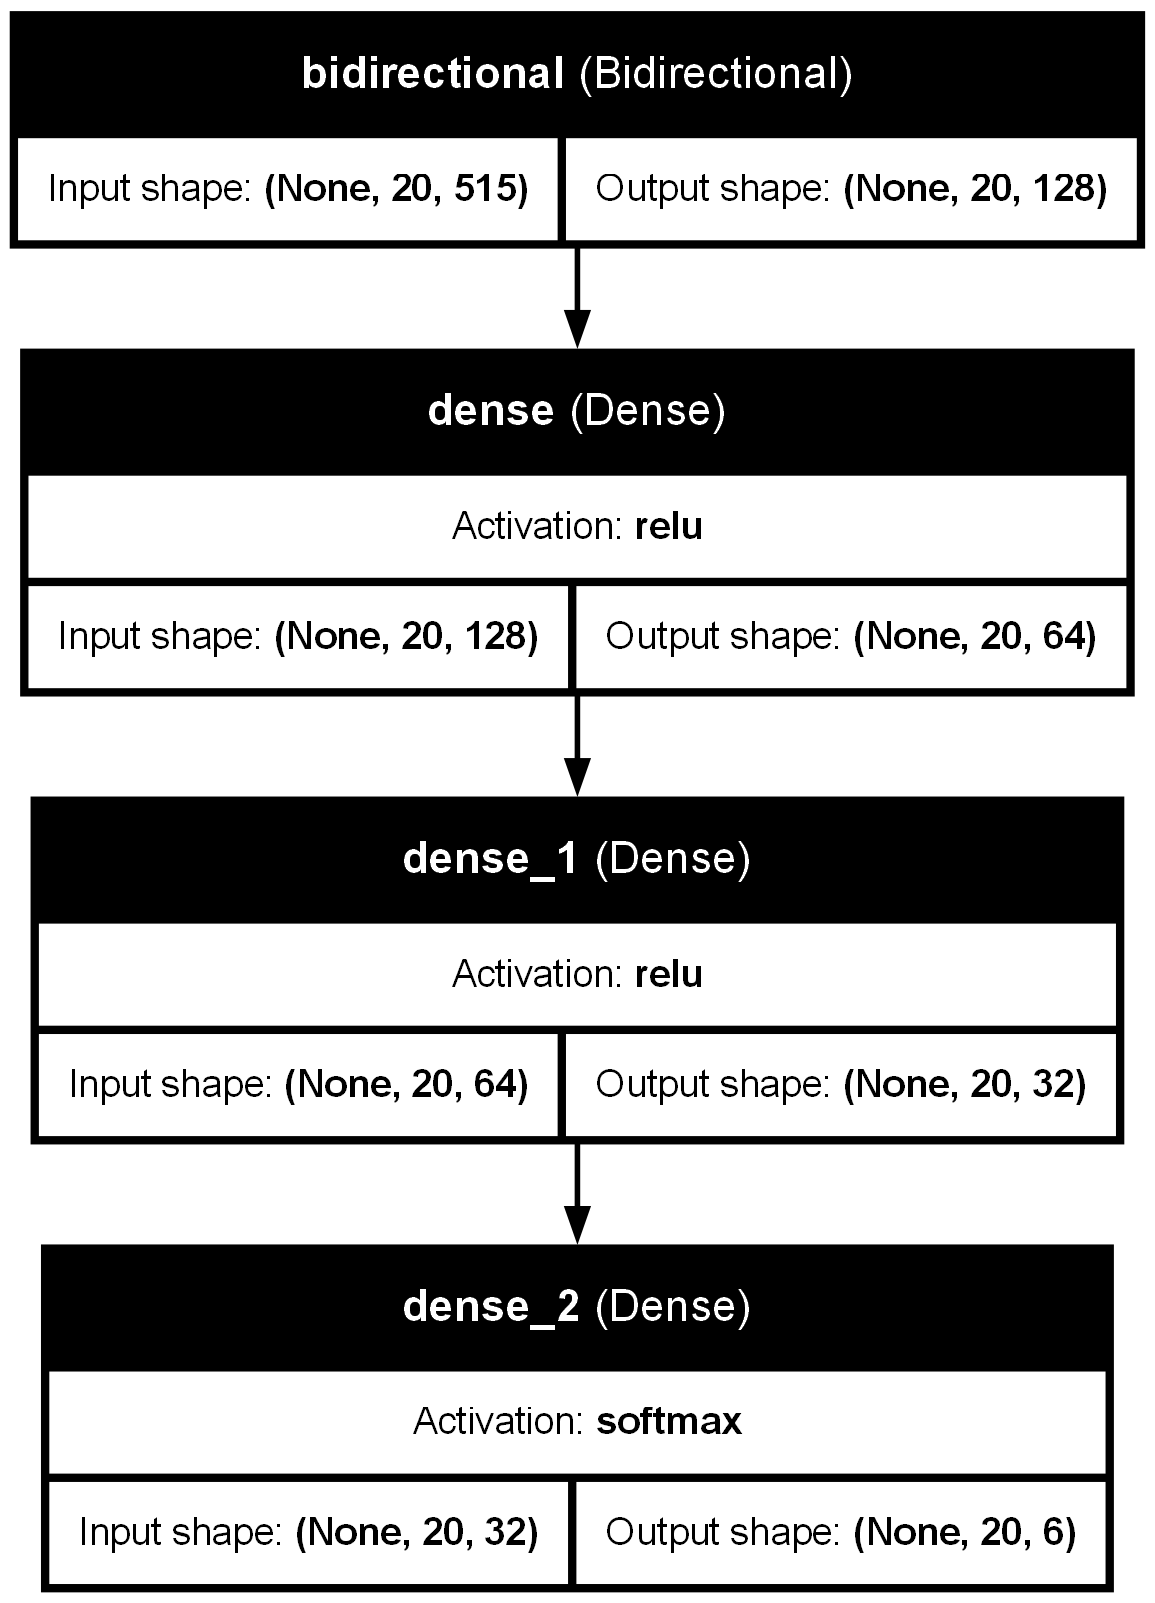

In [27]:
import keras

# Save and display the model architecture
keras.utils.plot_model(model_method_I, rankdir='TB', show_shapes=True, show_layer_names=True, show_layer_activations=True)


In [16]:
model_method_I.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [30]:
test_set = full_test_I
# Getting predictions (chat)
y_pred = model_method_I.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step


In [48]:
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
categorical_accuracy.update_state(y_true_valid, y_pred_valid)
print(f"Categorical Accuracy: {categorical_accuracy.result().numpy()}")

Categorical Accuracy: 0.8356643319129944


In [32]:
y_true_indices = np.argmax(y_true.numpy(), axis=-1).flatten()
y_pred_indices = np.argmax(y_pred, axis=-1).flatten()

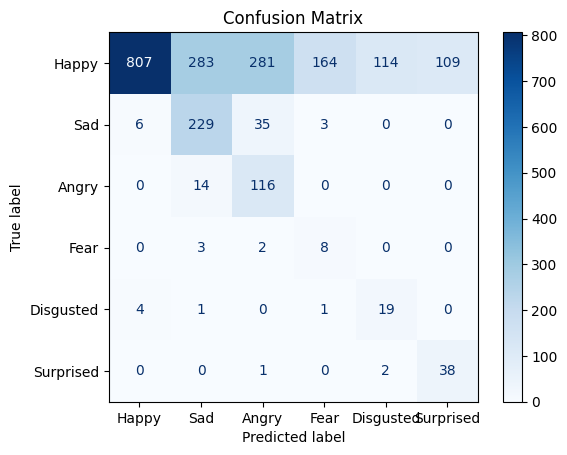

In [33]:
cm = confusion_matrix(y_true_indices, y_pred_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

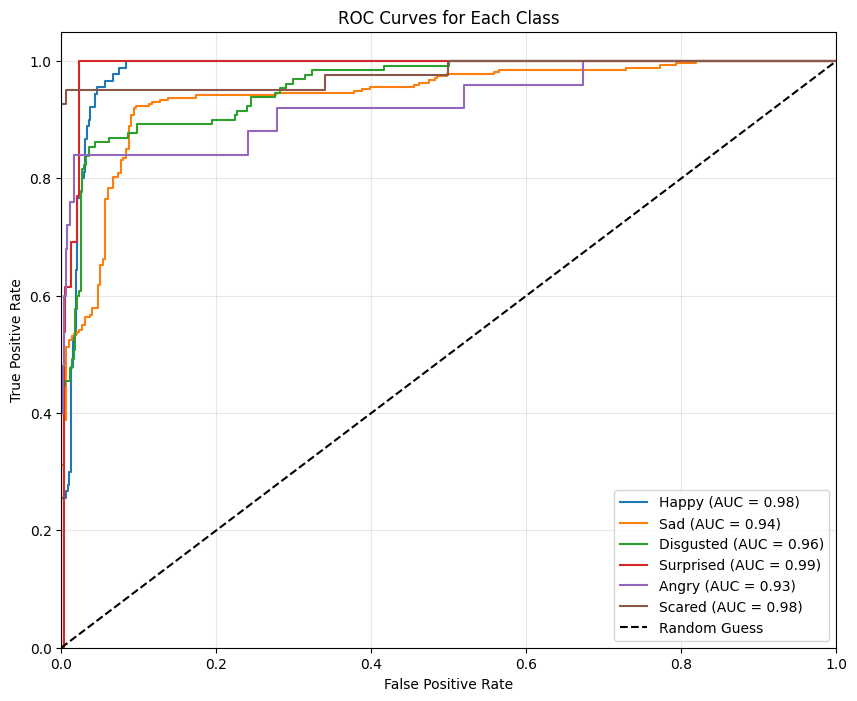

In [47]:
from sklearn.metrics import roc_curve, auc
y_true_flat = tf.reshape(y_true, [-1, 6]).numpy()  # Shape: (112*20, 6)
y_pred_flat = y_pred.reshape(-1, 6)  # Shape: (112*20, 6)
valid_indices = np.where(np.sum(y_true_flat, axis=-1) > 0)  # Find indices where y_true is not Neutral

# Apply the valid indices to both y_pred_labels and y_true_labels
y_pred_valid = y_pred_flat[valid_indices]
y_true_valid = y_true_flat[valid_indices]
# Initialize plot
plt.figure(figsize=(10, 8))
emotion_labels = ['Happy', 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared']  # Replace with actual class names

# Iterate over each class to calculate and plot ROC curve
for i, emotion in enumerate(emotion_labels):
    # Get true binary labels and predicted scores for this class
    y_true_binary = y_true_valid[:, i]
    y_pred_binary_scores = y_pred_valid[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 931ms/step


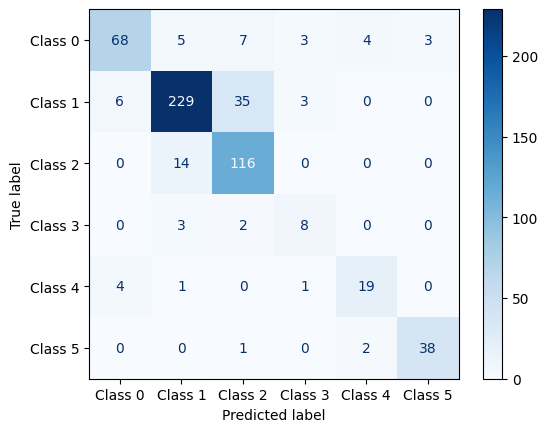

In [44]:
# Get predictions
y_pred = model_method_I.predict(test_set.map(lambda x, _: x))  # Shape: (num_samples, num_classes)

# Get true labels
y_true = tf.concat([y for _, y in test_set], axis=0)  # Shape: (num_samples, num_classes)

# Convert predictions to the most likely emotion (class with max probability)
y_pred_labels = np.argmax(y_pred, axis=-1)  # Shape: (num_samples,)
y_true_labels = np.argmax(y_true, axis=-1)  # Shape: (num_samples,)

# Filter out Neutral labels (where y_true is [0, 0, 0, 0, 0, 0])
valid_indices = np.where(np.sum(y_true, axis=-1) > 0)  # Find indices where y_true is not Neutral

# Apply the valid indices to both y_pred_labels and y_true_labels
y_pred_valid = y_pred_labels[valid_indices]
y_true_valid = y_true_labels[valid_indices]

# Compute confusion matrix using valid labels
cm = confusion_matrix(y_true_valid, y_pred_valid)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues')


In [39]:
from sklearn.metrics import roc_curve, auc

for i, emotion in enumerate(emotions):
    # Get true binary labels and predicted scores for this emotion
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_valid, y_pred_valid)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Emotions')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

ValueError: multiclass format is not supported

In [36]:
for i, emotion in enumerate(emotions):
    
    # Precision, Recall, F1 for this class
    true_class = (y_true_indices == i)
    pred_class = (y_pred_indices == i)
    precision = np.sum(true_class & pred_class) / np.sum(pred_class)
    recall = np.sum(true_class & pred_class) / np.sum(true_class)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"Metrics for {emotion}:")
    print(f"  Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

Metrics for Happy:
  Precision: 0.99, Recall: 0.46, F1-Score: 0.63
Metrics for Sad:
  Precision: 0.43, Recall: 0.84, F1-Score: 0.57
Metrics for Angry:
  Precision: 0.27, Recall: 0.89, F1-Score: 0.41
Metrics for Fear:
  Precision: 0.05, Recall: 0.62, F1-Score: 0.08
Metrics for Disgusted:
  Precision: 0.14, Recall: 0.76, F1-Score: 0.24
Metrics for Surprised:
  Precision: 0.26, Recall: 0.93, F1-Score: 0.40


In [37]:
# Initialize variables for micro-average calculation
total_true_positives = 0
total_predicted_positives = 0
total_actual_positives = 0

# Initialize list for macro-average calculation
precision_list = []
recall_list = []
f1_list = []

for i, emotion in enumerate(emotions):
    # Precision, Recall, F1 for this class
    true_class = (y_true_indices == i)
    pred_class = (y_pred_indices == i)
    
    true_positives = np.sum(true_class & pred_class)
    predicted_positives = np.sum(pred_class)
    actual_positives = np.sum(true_class)
    
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Append to macro-average lists
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    # Accumulate for micro-average
    total_true_positives += true_positives
    total_predicted_positives += predicted_positives
    total_actual_positives += actual_positives
    
    # Print metrics for this class
    print(f"Metrics for {emotion}:")
    print(f"  Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Micro-average calculations
micro_precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0
micro_recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0
micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

# Macro-average calculations
macro_precision = np.mean(precision_list)
macro_recall = np.mean(recall_list)
macro_f1 = np.mean(f1_list)

print("\nMicro-average metrics:")
print(f"  Precision: {micro_precision:.2f}, Recall: {micro_recall:.2f}, F1-Score: {micro_f1:.2f}")

print("\nMacro-average metrics:")
print(f"  Precision: {macro_precision:.2f}, Recall: {macro_recall:.2f}, F1-Score: {macro_f1:.2f}")


Metrics for Happy:
  Precision: 0.99, Recall: 0.46, F1-Score: 0.63
Metrics for Sad:
  Precision: 0.43, Recall: 0.84, F1-Score: 0.57
Metrics for Angry:
  Precision: 0.27, Recall: 0.89, F1-Score: 0.41
Metrics for Fear:
  Precision: 0.05, Recall: 0.62, F1-Score: 0.08
Metrics for Disgusted:
  Precision: 0.14, Recall: 0.76, F1-Score: 0.24
Metrics for Surprised:
  Precision: 0.26, Recall: 0.93, F1-Score: 0.40

Micro-average metrics:
  Precision: 0.54, Recall: 0.54, F1-Score: 0.54

Macro-average metrics:
  Precision: 0.36, Recall: 0.75, F1-Score: 0.39


## MODEL II

In [4]:
def masked_mean_squared_error(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.square(y_true - y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask[..., tf.newaxis]  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [5]:
model_method_II = tf.keras.models.load_model(
    '//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Models/model_method_II/model.keras', custom_objects={"masked_mean_squared_error": masked_mean_squared_error})

In [6]:
model_method_II.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 20, 128)        │       296,960 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [8]:
test_set = full_test_II
# Getting predictions (chat)
y_pred = model_method_II.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)
# Helper function to compute metrics for a single emotion
def compute_all_metrics(y_true, y_pred):
    """
    Compute MAS, MSE, MAE, RMSE, and R² for masked values of y_true and y_pred.
    
    Args:
        y_true (tf.Tensor): Ground truth values after masking.
        y_pred (tf.Tensor): Predicted values after masking.
    
    Returns:
        dict: A dictionary with computed metrics.
    """
    def compute_mse(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred)).numpy()

    def compute_mae(y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred)).numpy()

    def compute_rmse(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        return tf.sqrt(mse).numpy()

    def compute_r2(y_true, y_pred):
        total_variance = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        residual_variance = tf.reduce_sum(tf.square(y_true - y_pred))
        return (1 - residual_variance / total_variance).numpy()

    def compute_similarity(y_true, y_pred):
        similarity = 1 - tf.abs(y_true - y_pred)
        mas = tf.reduce_mean(similarity).numpy()
        label_count = tf.size(y_true).numpy()
        return mas, label_count

    # Compute metrics
    mse = compute_mse(y_true, y_pred)
    mae = compute_mae(y_true, y_pred)
    rmse = compute_rmse(y_true, y_pred)
    r2 = compute_r2(y_true, y_pred)
    mas, label_count = compute_similarity(y_true, y_pred)

    return {
        'Labels Used': label_count,
        'MAS': mas,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

# Main loop to compute metrics for all emotions
def compute_metrics_for_all_emotions(y_true, y_pred, emotions):
    """
    Compute all metrics for each emotion.
    
    Args:
        y_true (tf.Tensor): Ground truth values (shape: [batch_size, sequence_length, num_emotions]).
        y_pred (tf.Tensor): Predicted values (shape: [batch_size, sequence_length, num_emotions]).
        emotions (list): List of emotion names.
    
    Returns:
        list: A list of dictionaries containing metrics for each emotion.
    """
    metric_results = []

    for i, emotion in enumerate(emotions):
        # Extract true and predicted values for the specific emotion
        true_values = tf.cast(y_true[:, :, i], tf.float32)
        pred_values = tf.cast(y_pred[:, :, i], tf.float32)
        
        # Mask non-zero true values
        mask = tf.not_equal(true_values, 0)
        true_values_masked = tf.boolean_mask(true_values, mask)
        pred_values_masked = tf.boolean_mask(pred_values, mask)
        
        # Compute all metrics using the helper function
        metrics = compute_all_metrics(true_values_masked, pred_values_masked)
        metrics['emotion'] = emotion  # Add emotion name to the result
        
        # Append to results
        metric_results.append(metrics)

        # Print for immediate feedback
        print(f"Emotion: {emotion}, Metrics: {metrics}")

    return metric_results

# Example Usage
# Assuming `emotions` is a list of emotion names, and `y_true` and `y_pred` are already defined
results = compute_metrics_for_all_emotions(y_true, y_pred, emotions)

# Results are already printed inside the loop


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step
Emotion: Happy, Metrics: {'Labels Used': 1733, 'MAS': 0.7714122, 'MSE': 0.092365295, 'MAE': 0.22858784, 'RMSE': 0.3039166, 'R²': -0.5547128, 'emotion': 'Happy'}
Emotion: Sad, Metrics: {'Labels Used': 1020, 'MAS': 0.82074165, 'MSE': 0.056170255, 'MAE': 0.17925833, 'RMSE': 0.23700264, 'R²': -1.7504737, 'emotion': 'Sad'}
Emotion: Angry, Metrics: {'Labels Used': 764, 'MAS': 0.84800553, 'MSE': 0.042449046, 'MAE': 0.15199442, 'RMSE': 0.20603167, 'R²': 0.14819503, 'emotion': 'Angry'}
Emotion: Fear, Metrics: {'Labels Used': 426, 'MAS': 0.7566955, 'MSE': 0.06877991, 'MAE': 0.2433045, 'RMSE': 0.26225924, 'R²': -18.03748, 'emotion': 'Fear'}
Emotion: Disgusted, Metrics: {'Labels Used': 286, 'MAS': 0.803003, 'MSE': 0.05415352, 'MAE': 0.19699703, 'RMSE': 0.2327091, 'R²': -5.1655345, 'emotion': 'Disgusted'}
Emotion: Surprised, Metrics: {'Labels Used': 409, 'MAS': 0.7801965, 'MSE': 0.06328549, 'MAE': 0.21980351, 'RMSE': 0.25156608, 'R²': -5.600141, 'emotion': '